In [257]:
import pandas as pd
import numpy as np
import numpy.typing as npt
np. sqrt(3)
from typing import List
import matplotlib.pyplot as plt
import sys
import copy
import warnings
import statsmodels
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.tools.eval_measures import bic
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *
from stargazer import stargazer

In [258]:
def ols_crossvalidator(
    formula: str, data: pd.DataFrame, n_folds=5, average_rmse=True
) -> dict:
    """OLS cross-validator


    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.

    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.

    """

    # Get dependent variable

    y = formula.split("~")[0].strip()

    # Get statistics on the whole work data

    model = smf.ols(formula, data=data).fit()

    rsquared = model.rsquared
    # n_coefficients = model.params.shape[0]
    n_coefficients = (
        model.df_model + 1
    )  # This might differ from model.params.shape[0], because of collinear predictors
    bic = model.bic
    rmse_alldata = rmse(model.predict(), data[y])

    # Calculating test and train RMSE-s for each fold

    k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

    rmse_train = []
    rmse_test = []

    for train_index, test_index in k.split(data):

        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]

        model = smf.ols(formula, data=data_train).fit()

        rmse_train.append(rmse(data_train[y], model.predict(data_train)))
        rmse_test.append(rmse(data_test[y], model.predict(data_test)))

    if average_rmse:
        rmse_train = np.mean(rmse_train)
        rmse_test = np.mean(rmse_test)

    return {
        "RMSE": rmse_alldata,
        "R-squared": rsquared,
        "BIC": bic,
        "Coefficients": n_coefficients,
        "Training RMSE": rmse_train,
        "Test RMSE": rmse_test,
    }


import statsmodels


def point_predict_with_conf_int(
    regression: statsmodels.regression.linear_model.RegressionResultsWrapper,
    new_datapoint: pd.DataFrame,
    interval_precision=0.95,
    round_n=2,
) -> dict:
    """
    Does point prediction and interval prediction for a new datapoint.

        Parameters
    ----------
    regression : statsmodels.regression.linear_model.RegressionResultsWrapper
        Fitted regression model.
    new_datapoint : pd.DataFrame
        Database containing a new observation.
    interval_precision : float, default=0.95
        Precision of interval prediction.
    round_n: int, default=2
        Decimals to round floats in output.
    """

    summaryframe = regression.get_prediction(new_datapoint).summary_frame(
        alpha=1 - interval_precision
    )

    point_prediction = round(summaryframe["mean"].values[0], round_n)

    conf_int = [
        round(i, round_n)
        for i in summaryframe[["obs_ci_lower", "obs_ci_upper"]].values[0]
    ]

    if round_n == 0:
        point_prediction = int(point_prediction)
        conf_int = [int(i) for i in conf_int]
    else:
        pass

    return {
        "Point prediction": point_prediction,
        f"Prediction Interval ({round(interval_precision*100)}%)": conf_int,
    }





#Current working directory
current_dir = os.getcwd()
#Opening the csv file
data_all = pd.read_csv(current_dir + "/morg-2014-emp.csv")

In [259]:
# Count the number of observations for each occupation
count = data_all["occ2012"].value_counts()
threshold = 1800
print(count[count > threshold])

occ2012
2310    3636
5700    3511
3255    3455
430     3352
4720    3327
4760    3226
9130    3189
4700    3057
4220    2464
5240    2329
3600    2224
4110    2178
4020    2147
9620    2015
800     1815
Name: count, dtype: int64


In [260]:
# Choosing Occupation and dropping occ2012 if it is not 1800 / economists
data = data_all[data_all["occ2012"] == 1800]
data["occ2012"].value_counts()

occ2012
1800    71
Name: count, dtype: int64

In [261]:
#Creating variables
data["female"] = (data.sex == 2).astype(int)
data['sex'].value_counts()
data["w"] = data["earnwke"] / data["uhours"]
data["agesqr"] = data["age"] ** 2
data['lnw'] = np.log(data['w'])

In [277]:
#Model 1: regression on age, age squared, gender, and education
reg1 = smf.ols(
    "w ~ age + agesqr + female", 
    data=data
    ).fit(cov_type="HC0")
reg2 = smf.ols(
    "w ~ age + agesqr + female + uhours", 
    data=data
    ).fit(cov_type="HC0")
reg3 = smf.ols(
    "w ~ age + agesqr + female + uhours + marital ", 
    data=data
    ).fit(cov_type="HC0")
reg4 = smf.ols(
    "w ~ age + agesqr + female + uhours + marital + C(unionmme)", 
    data=data
    ).fit(cov_type="HC0")

In [278]:
robustcov_results = []
for model in models:
    result=model.get_robustcov_results(cov_type='HC1').summary()
    robustcov_results.append(result)
    print(result)

                            OLS Regression Results                            
Dep. Variable:                    lnw   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     706.2
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           8.87e-56
Time:                        22:28:47   Log-Likelihood:                -27.687
No. Observations:                  71   AIC:                             71.37
Df Residuals:                      63   BIC:                             89.48
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1041      0.934  

In [311]:
from stargazer.stargazer import Stargazer, LineLocation
mod1 = smf.ols("lnw ~ age + agesqr + female", data=data).fit(cov_type="HC1")
mod2 = smf.ols("lnw ~ age + agesqr + female + C(unionmme)", data=data).fit(cov_type="HC1")
mod3 = smf.ols("lnw ~ age + agesqr + female + C(unionmme) + uhours + marital", data=data).fit(cov_type="HC1")
mod4 = smf.ols("lnw ~ age + agesqr + female + C(unionmme) + uhours + marital", data=data).fit(cov_type="HC1")

models = [mod1, mod2, mod3, mod4]
bic_values = [model.bic for model in models]
starg = Stargazer(models)
starg.covariate_order(["age", "agesqr", "female"])
    
starg.add_line("BIC", [f'{bic:.0f}' for bic in bic_values], LineLocation.FOOTER_BOTTOM) 
starg

In [312]:
for i, model in enumerate(models, start=1):
    result = model.get_robustcov_results(cov_type='HC1')
    print(f"BIC for model {i}: {result.bic}")

BIC for model 1: 83.87526995988574
BIC for model 2: 85.27104178476078
BIC for model 3: 91.64584794902592
BIC for model 4: 91.64584794902592


In [313]:
from sklearn.metrics import mean_squared_error
# Assuming 'w' is the dependent variable in your regression
for i, model in enumerate(models):
    # Assuming 'data' is your input data
    y_pred = model.predict(data)

    # Handle NaN values in the true values (data['w'])
    y_true = data['w'].fillna(data['w'].mean())

    rmse_value = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"RMSE for Model {i + 1}: {rmse_value}")

RMSE for Model 1: 40.71021319328508
RMSE for Model 2: 40.70461536503173
RMSE for Model 3: 40.70044932425455
RMSE for Model 4: 40.70044932425455


In [315]:
def ols_crossvalidator(
    formula: str, data: pd.DataFrame, n_folds=5, average_rmse=True
) -> dict:
    """OLS cross-validator

    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.

    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.

    Returns
    -------
    dict
        Dictionary containing RMSE, R-squared, BIC, No. coefficients, Training RMSE,
        and Test RMSE.

    """

    # Get dependent variable
    y = formula.split("~")[0].strip()

    # Get statistics on the whole work data
    model = smf.ols(formula, data=data).fit()
    rsquared = model.rsquared
    n_coefficients = model.df_model + 1
    bic = model.bic
    rmse_alldata = rmse(model.predict(), data[y])

    # Calculating test and train RMSE-s for each fold
    k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

    rmse_train = []
    rmse_test = []

    for train_index, test_index in k.split(data):

        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]

        model = smf.ols(formula, data=data_train).fit()

        rmse_train.append(rmse(data_train[y], model.predict(data_train)))
        rmse_test.append(rmse(data_test[y], model.predict(data_test)))

    if average_rmse:
        rmse_train = np.mean(rmse_train)
        rmse_test = np.mean(rmse_test)

    return {
        "RMSE": rmse_alldata,
        "R-squared": rsquared,
        "BIC": bic,
        "Coefficients": n_coefficients,
        "Training RMSE": rmse_train,
        "Test RMSE": rmse_test,
    }

result1 = ols_crossvalidator("lnw ~ age + agesqr + female", data, n_folds=4)
result2 = ols_crossvalidator("lnw ~ age + agesqr + female + C(unionmme)", data, n_folds=4)
result3 = ols_crossvalidator("lnw ~ age + agesqr + female + C(unionmme)+ uhours", data, n_folds=4)
result4 = ols_crossvalidator("lnw ~ age + agesqr + female + C(unionmme)+ uhours + marital", data, n_folds=4)

results_df = pd.DataFrame([result1, result2, result3, result4])

# Print the DataFrame
print(results_df)

       RMSE  R-squared        BIC  Coefficients  Training RMSE  Test RMSE
0  0.387382   0.211317  83.875270           4.0       0.384349   0.401954
1  0.379640   0.242529  85.271042           5.0       0.375375   0.404308
2  0.379392   0.243518  89.440896           6.0       0.374642   0.407753
3  0.373933   0.265128  91.645848           7.0       0.368300   0.406290


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


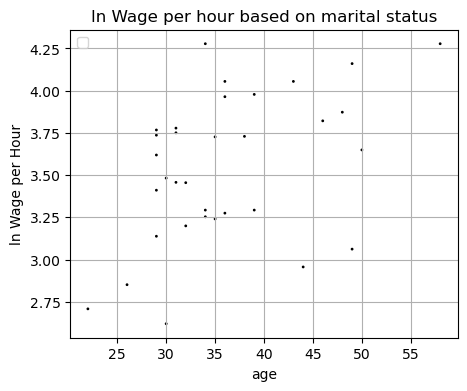

In [316]:
plt.figure(figsize=(5, 4))
plt.scatter(data['age'], data['lnw'], data["female"], color='black')
plt.title("ln Wage per hour based on marital status of females")
plt.xlabel('age')
plt.ylabel('ln Wage per Hour')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


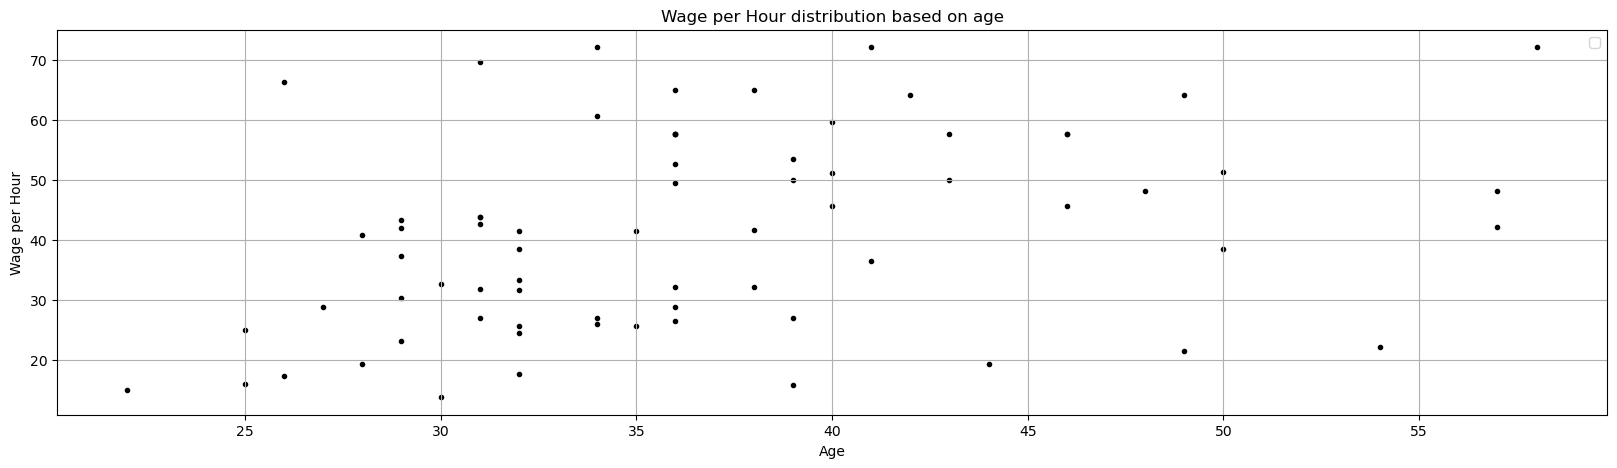

In [299]:
plt.figure(figsize=(20, 5))
plt.scatter(data['age'], data['w'], color='black', marker='.')
plt.title("Wage per Hour distribution based on age")
plt.xlabel('Age')
plt.ylabel('Wage per Hour')
plt.legend()
plt.grid(True)
plt.show()

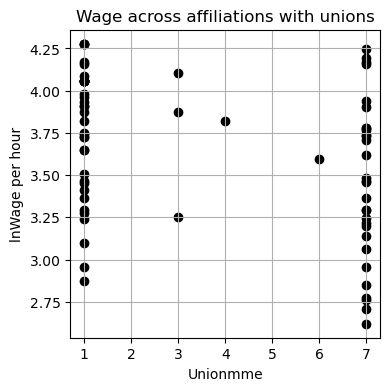

In [302]:
plt.figure(figsize=(4, 4))
plt.scatter(data["marital"], data['lnw'], color='black')
plt.title("Wage across affiliations with unions")
plt.xlabel("Unionmme")
plt.ylabel("lnWage per hour")
plt.grid(True)
plt.show()

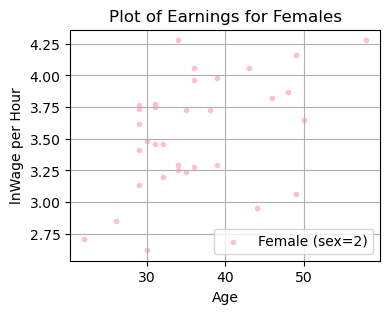

In [307]:
data_female = data[data['sex'] == 2]

plt.figure(figsize=(4, 3))
plt.scatter(data_female['age'], data_female['lnw'], color='pink', marker='.', label='Female (sex=2)')
plt.title('Plot of Earnings for Females')
plt.xlabel('Age')
plt.ylabel('lnWage per Hour')
plt.legend()
plt.grid(True)
plt.show()

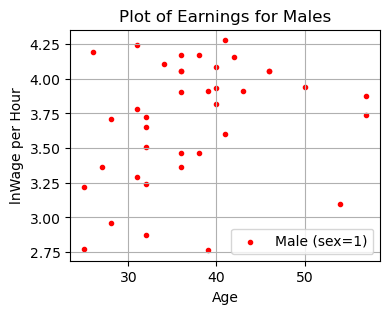

In [309]:
data_male = data[data['sex'] == 1]
plt.figure(figsize=(4, 3))
plt.scatter(data_male['age'], data_male['lnw'], color='red', marker='.', label='Male (sex=1)')
plt.title('Plot of Earnings for Males')
plt.xlabel('Age')
plt.ylabel('lnWage per Hour')
plt.legend()
plt.grid(True)
plt.show()